Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Se normalizaron los datos con MinMaxScale

In [1]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [2]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [3]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [4]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

#Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()

#Aplicamos MinMaxScaler a los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ShanghaiDat = scaler.fit_transform(ShanghaiDat.reshape(-1, 1)).flatten()


#Dividimos en epocas de n dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [5]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [6]:
#Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512):
        super(TransformerModel, self).__init__() 
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(input_size * sequence_length, 1)

    def forward(self, src):
        src = src.reshape(-1, self.sequence_length, 1) 
        src = src.flatten(start_dim=1) 
        src = src.unsqueeze(0) 
        out = self.transformer_encoder(src) 
        out = out.squeeze(0) 
        return self.fc_out(out) 

In [7]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

#Training loop
losses=[]
for epoch in range(300):
    for seq, next_point in dataloader:
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) 
        output = model(seq)
        loss = criterion(output, next_point) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.01042818184942007
Epoch 2, Loss: 0.0023999165277928114
Epoch 3, Loss: 0.0030855149962008
Epoch 4, Loss: 0.0036497307009994984
Epoch 5, Loss: 0.002172613749280572
Epoch 6, Loss: 0.0017141835996881127
Epoch 7, Loss: 0.001058794790878892
Epoch 8, Loss: 0.0006798161193728447
Epoch 9, Loss: 0.0012814425863325596
Epoch 10, Loss: 0.0005611794767901301
Epoch 11, Loss: 0.001590388361364603
Epoch 12, Loss: 0.0009547394583933055
Epoch 13, Loss: 0.0008339216001331806
Epoch 14, Loss: 0.0009707564604468644
Epoch 15, Loss: 0.0008967847679741681
Epoch 16, Loss: 0.000414161360822618
Epoch 17, Loss: 0.0009920777520164847
Epoch 18, Loss: 0.0013320940779522061
Epoch 19, Loss: 0.0010727826738730073
Epoch 20, Loss: 0.0003281265962868929
Epoch 21, Loss: 0.0013043152866885066
Epoch 22, Loss: 0.0010779035510495305
Epoch 23, Loss: 0.0015351817710325122
Epoch 24, Loss: 0.0006875729886814952
Epoch 25, Loss: 0.0005949140759184957
Epoch 26, Loss: 0.0006998764001764357
Epoch 27, Loss: 0.000757057336

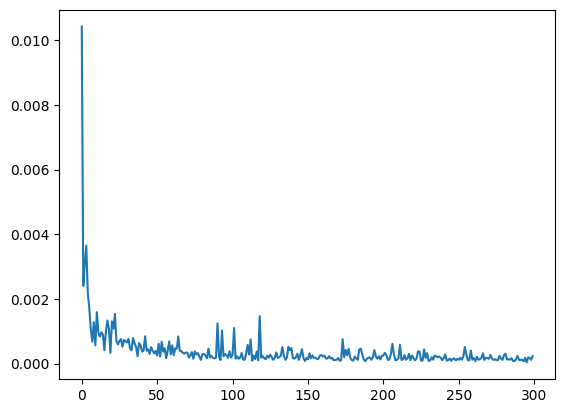

In [9]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [ ]:
# Veamos cómo predice el modelo

# Tomamos una secuencia ya escalada (por ejemplo, la primera del dataset)
test_seq = sequences[0].reshape(-1, 1)  # La convertimos a forma columna
test_seq = scaler.transform(test_seq).flatten()  # La reescalamos (aunque ya estaba escalada, es por claridad y generalidad)

# Convertimos a tensor y agregamos dimensión de batch
test_seq_tensor = torch.tensor(test_seq).float().unsqueeze(0).to(device)

# Obtenemos la predicción del modelo
with torch.no_grad():
    predicted_scaled = model(test_seq_tensor)

# Convertimos de vuelta a numpy
predicted_scaled_np = predicted_scaled.cpu().numpy()

# Desescalamos la predicción a su valor original
predicted_real = scaler.inverse_transform(predicted_scaled_np)

print("Predicción:", predicted_real.item())
print("Dato siguiente real:", scaler.inverse_transform([[next_points[0]]])[0][0])


Predicción (dato siguiente real): 1014.562255859375
Dato siguiente real original: 1204.39404296875


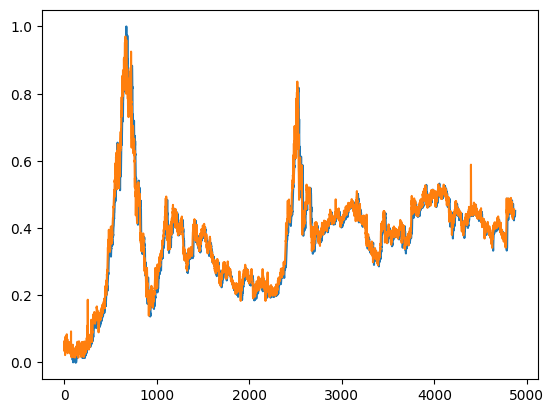

In [ ]:
#Comparemos los datos reales con las predicciones que hace el modelo
predicciones=[]
for i in sequences:
    test_seq = torch.tensor(i).float()
    test_seq = test_seq.unsqueeze(0)
    test_seq = test_seq.to(device)
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())


plt.plot(ShanghaiDat)
plt.plot(predicciones)
plt.show()

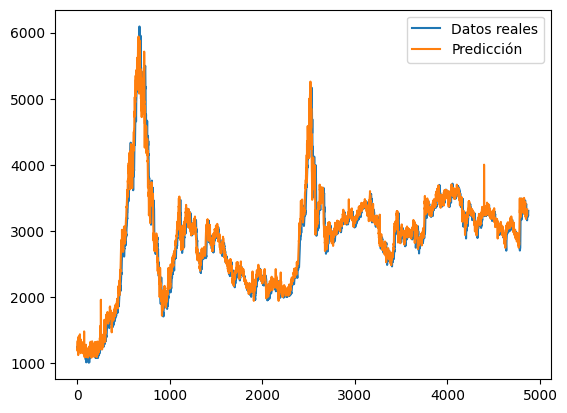

In [12]:
#Graficamos los datos desnormalizados
predicciones_array = np.array(predicciones).reshape(-1, 1)

predicciones_desnormalizadas = scaler.inverse_transform(predicciones_array)
ShanghaiDat_desnormalizado = scaler.inverse_transform(ShanghaiDat.reshape(-1, 1))

plt.plot(ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(predicciones_desnormalizadas, label='Predicción')
plt.legend()
plt.show()